# RISM - A Gentle Introduction

We are going to write a Python implementation of the extended RISM equation with the goal of computing the direct, indirect and total correlation function along with the radial distribution function.

First, we import the libraries we will be needing:

In [1]:
import numpy as np
from scipy.fftpack import dstn, idstn
from scipy.special import erf
import matplotlib.pyplot as plt

First, we need to set up our problem domain. While the RISM equations are written as continuous functions $r$ (e.g. $c(r)$), computationally we solve them on a discretised grid.

We'll set up a discrete domain of length (or radius since we are working with spherically symmetric functions) $r = 15\, Å$ partitioned into $N = 100$ points. The resulting grid spacing is given by $\Delta r = \frac{r}{N}$.

In [2]:
r = 15.0
N = 100
dr = r / N

We also want to set up a grid spacing for our Fourier-space grid such that $\Delta r \Delta k = \frac{\pi}{N}$

In [3]:
dk = 2.0 * np.pi / (2.0 * N * dr)

Lets check the equality we stated above:

In [4]:
np.isclose(dr * dk, np.pi / N)

True

We use `np.isclose()` here because we are comparing floating point numbers. Using `==` would not work since there is always some precision loss with floats. You need to compared them within tolerances instead.

We can use these to generate our real and Fourier-space midpoint grids.

In [5]:
r_grid = np.arange(0.5, N, 1.0) * dr
k_grid = np.arange(0.5, N, 1.0) * dk

## Simple Argon Liquid

Now that we have our problem domain set up, we can focus on solving a particular problem. We're going to look at solving RISM for a simple Lennard-Jones Argon liquid system.

We first need to set up the thermodynamical state of the system and the unit systems we're going to use. We'll be working with energies in kJ / mol.

In [6]:
T = 300.0 # Kelvin
kB = 8.314462618e-3 # kJ / mol / K
beta = 1.0 / T / kB # Thermodynamic Beta

We also need to define the parameters for Argon, as well as its number density. 

In [7]:
epsilon = 0.99773551416 # kJ / mol
sigma = 3.4 # Angstroms
rho = 0.021017479720736955

We need to tabulate the LJ potential with the above parameters. We define a function to evaluate the potential over a grid, and then we plot the potential.

In [8]:
def LJ(epsilon, sigma, r):
    return 4.0 * epsilon * ( np.power( (sigma / r), 12) - np.power( (sigma / r), 6) )

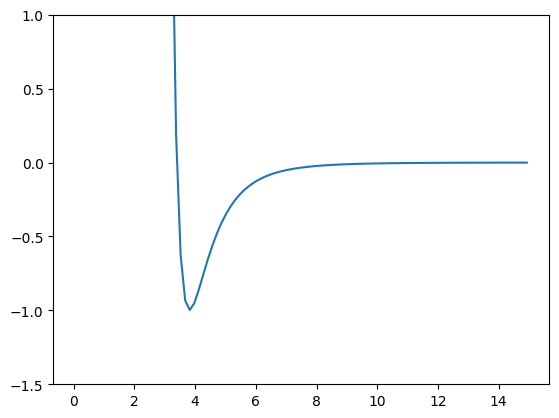

In [9]:
ur = LJ(epsilon, sigma, r_grid)

plt.plot(r_grid, ur)
plt.ylim([-1.5, 1.0])
plt.show()

One aspect of the RISM equation that we need to consider is the intramolecular correlation function $\omega(k)$. In the case of a simple liquid, $\omega(k) = 1$, in which case we the RISM equation reduces to the Ornstein-Zernike (OZ) equation.
We'll implement the full RISM equation, but we will set $\omega(k)$ to 1 for the case our current system.

In [10]:
wk = np.ones(N)

Another aspect is the closure. The closure is what relates our unknowns ($h(r)$ and $c(r)$), in a sense "closing" the RISM equation.
Generally the closure in terms of $c(r)$ is $$ c(r) = e^{-\beta u(r) + t(r) - B(r)} - t(r) - 1 $$ where $B(r)$ is the bridge function - something that we need to approximate - and $t(r) = h(r) - c(r)$ is the indirect correlation function.

We're going to use the simplest approximation, $B(r) = 0$. This is the Hypernetted Chain (HNC) closure.

$$ c(r) = e^{-\beta u(r) + t(r)} - t(r) - 1 $$

In [11]:
def HNC(beta, ur, tr):
    return np.exp(-beta * ur + tr) - 1.0 - tr

The final detail before we implement the RISM equation is that we need to be able to transform our correlation functions into Fourier-space and back.
We use the Fourier transforms of spherically symmetric functions:

$$ f(k) = 4 \pi \int_0^\infty f(r) r^2 \frac{\sin(kr)}{kr} dr $$

and the inverse:

$$ f(r) = \frac{1}{2 \pi^2} \int_0^\infty f(k) k^2 \frac{\sin(kr)}{kr} dk $$

The function $J_0(kr) = \frac{\sin(kr)}{kr}$ is the zeroth-order spherical Bessel function of the first kind, so sometimes these transforms are called Fourier-Bessel (or Hankel) transforms.

This can neatly be related to the Fourier sine transform:

$$ f(k) = \int_0^\infty f(r) \sin(kr) dr $$

$$ f(r) = \frac{2}{\pi} \int_0^\infty f(k) \sin(kr) dk $$

So that the fourier transform of the spherically symmetric function $f(r)$ is just the Fourier sine transform of the function $f(r) \cdot r$

Scipy has discrete sine transform functions we can use.

In [12]:
def fbt(fr, r, k, dr):
    return 2.0 * np.pi * dr * dstn(fr * r, type=4, axes=[0]) / k

def ifbt(fk, r, k, dk):
    return dk / 4.0 / np.pi / np.pi * idstn(fk * k, type=4, axes=[0]) / r

We have all the key parts to solve the RISM equation now.
The equation in Fourier-space is $$h(k) = \omega(k) * c(k) * \omega(k) - \rho * \omega(k) * c(k) * h(k)$$
We can rearrange this for $h(k)$ $$h(k) = [1 - \rho * \omega(k) * c(k)]^{-1} \omega(k) * c(k) * \omega(k)$$

For brevity, I'm going to drop the function argument $(k)$
$$h = [1 - \rho\omega c]^{-1} \omega c \omega$$

We're interested in calculating the indirect correlation function $t(k)$ $$t = [1 - \rho\omega c]^{-1} \omega c \omega - c$$

In [13]:
def RISM(cr, w, p, r, k, dr, dk):
    # Transform c(r) to c(k)
    ck = fbt(cr, r, k, dr)
    # Solve the RISM equation for t(k)
    tk = w * ck * w / (1.0 - p * w * ck) - ck
    # Transform t(k) to t(r)
    tr = ifbt(tk, r, k, dk)
    return tr

We have all the equations we need to perform a single closure and RISM calculation. Now we need to numerically solve this problem.

The RISM equation is an integro-differential equation, and is posed to be solved using fixed-point iteration (i.e. the self-consistent approach used in electronic structure theory e.g. for solving Hartree-Fock).

We set some initial guess for $t_0(r)$, and use that as input into the closure and RISM equation, and get a new value out. If we represent the closure and RISM equation as an operator $F(\cdot)$ on $t(r)$ then we get a value of $F(t(r))$.

We can then mix this new value with our initial value to obtain a new solution for $t(r)$ $$t_1(r) = \alpha F(t_0(r))  + (1 - \alpha) t_0(r) $$

More generally $$t_{k+1}(r) = \alpha F(t_k(r)) + (1 + \alpha) t_k(r)$$

where $\alpha$ is a dampening parameter. The lower this is, the stiffer our iteration process is (because we're including more of the previous solution than the current). This is called Picard iteration.


We keep iterating this set of equations and check the difference between current and previous solutions until that difference is below some tolerance $\zeta$ $$ |t_{k+1}(r) - t_{k}(r)| < \zeta $$

Once the difference is below this tolerance, the calculation is finished.

We use an initial guess of $t(r) = 0$ and a tolerance of $\zeta = 1\times10^{-8}$

In [14]:
# Setting up parameters for iterations
tolerance = 1e-8
max_steps = 1000
step = 0

# 1.0 is essentially undamped direct iteration
alpha = 1.0

# Setting up initial guess
tr = np.zeros(N)

while step < max_steps:
    # Store previous t(r)
    tr_prev = tr

    # t(r) -> c(r) from closure
    cr = HNC(beta, ur, tr)

    # c(r) -> F(t(r)) from RISM equation
    f_tr = RISM(cr, wk, rho, r_grid, k_grid, dr, dk)

    # Use Picard iteration to get the new solution
    # Since we set alpha = 1.0 above, this is 
    # essentially direct iteration (tr_new = f_tr).
    tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev
    
    # Check the absolute value of the difference between the current and previous solution
    # We use .max() because we want to check that all values are below the tolerance, and
    # if the maximum value of the difference array is below, then so must the other values be.
    # We multiply by dr to normalise this over grid spacing
    diff = abs((tr_new - tr_prev).max()) * dr
    
    # Set t(r) to the new t(r) we just computed
    tr = tr_new

    # Print the iteration step and difference
    print("Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))

    # Test if the difference is below our tolerance
    if diff < tolerance:
        break

    # Update our step counter. We have a max_step because we don't want this calculation to go 
    # on forever and freeze our PC.
    step += 1

Iteration: 0 Diff: 3.97e-01
Iteration: 1 Diff: 7.66e-02
Iteration: 2 Diff: 1.34e-01
Iteration: 3 Diff: 1.24e-01
Iteration: 4 Diff: 9.47e-02
Iteration: 5 Diff: 9.37e-02
Iteration: 6 Diff: 8.38e-02
Iteration: 7 Diff: 7.53e-02
Iteration: 8 Diff: 7.03e-02
Iteration: 9 Diff: 6.43e-02
Iteration: 10 Diff: 5.93e-02
Iteration: 11 Diff: 5.51e-02
Iteration: 12 Diff: 5.11e-02
Iteration: 13 Diff: 4.75e-02
Iteration: 14 Diff: 4.42e-02
Iteration: 15 Diff: 4.12e-02
Iteration: 16 Diff: 3.85e-02
Iteration: 17 Diff: 3.60e-02
Iteration: 18 Diff: 3.37e-02
Iteration: 19 Diff: 3.15e-02
Iteration: 20 Diff: 2.96e-02
Iteration: 21 Diff: 2.77e-02
Iteration: 22 Diff: 2.60e-02
Iteration: 23 Diff: 2.44e-02
Iteration: 24 Diff: 2.30e-02
Iteration: 25 Diff: 2.16e-02
Iteration: 26 Diff: 2.03e-02
Iteration: 27 Diff: 1.91e-02
Iteration: 28 Diff: 1.80e-02
Iteration: 29 Diff: 1.70e-02
Iteration: 30 Diff: 1.60e-02
Iteration: 31 Diff: 1.51e-02
Iteration: 32 Diff: 1.42e-02
Iteration: 33 Diff: 1.34e-02
Iteration: 34 Diff: 1.27

Once solved, we can use the calculated correlation functions to calculate the radial distribution function and plot it.

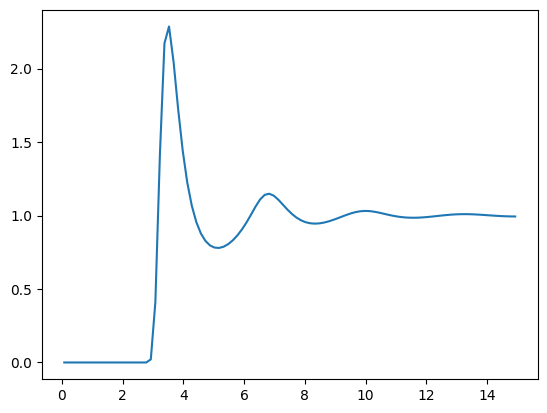

In [15]:
# Get c(r) from the solved t(r)
cr = HNC(beta, ur, tr)

# Get h(r)
hr = tr + cr

# Get and plot g(r)
gr = hr + 1

plt.plot(r_grid, gr)
plt.show()

This is the radial distribution function for a Lennard-Jones Argon liquid!

On your machine you might find that it took over 300 iterations to come to a solution.
We're using a very simple iteration scheme, but there are more complex iteration schemes we can use that can reduce the number of iterations.
We will look at one convergence acceleration method later, but most methods are beyond the scope of this tutorial.

## Nitrogen - Introducing Molecular Liquids and the Coulomb Potential

We want to look at more than just simple Lennard-Jones fluids. We can consider an uncharged homonuclear diatomic molecule, and nitrogen is a good such example.
Lets define the parameters, system and units.

In [16]:
T = 72.0 # Kelvin
kB = 8.314462618e-3 # kJ / mol / K
beta = 1.0 / T / kB # Thermodynamic Beta

n2_epsilon = 0.3658363552 # kJ / mol
n2_sigma = 3.341 # Angstroms

Notice that we've defined a bond length here. We need this for computing the $\omega(k)$.

First we need to define the shape of our arrays. We're still working $N$ grid points but we're now dealing with 2 atoms (or sites in the terminology of RISM).

It's useful to define a variable for our system size.

In [17]:
ns = 2 # Number of sites

wk = np.zeros((N, ns, ns)) # 3D array of number of points X number of sites X number of sites

Now we need to define what the intramolecular correlation function looks like $$\omega_{ij}(k) = \delta_{ij} + (1 - \delta_{ij})\frac{\sin(kd_{ij})}{kd_{ij}}$$
where $\delta_{ij}$ is the Kronecker delta, and $d_{ij}$ is the distance between site $i$ and $j$.


For nitrogen, we can explicitly define these for each $ij$ pair. If we number both nitrogens as $\textrm{N}_1$ and $\textrm{N}_2$ and we state the bond length between them to be $1.1\, Å$ then we can write 

$$\omega_{\textrm{N}_1 \textrm{N}_1} = \omega_{\textrm{N}_2 \textrm{N}_2} = 1$$

$$\omega_{\textrm{N}_1 \textrm{N}_2} = \omega_{\textrm{N}_2 \textrm{N}_1} = \frac{\sin(1.1k)}{1.1k}$$

In [18]:
n2_bond_length = 1.1

# [:, 0, 0] indicates a slice over the first axis (which we defined as the number of points above, and indexing the last 2 axes explicitly with 0 and 0 (or 1 and 1) etc.
wk[:, 0, 0] = wk[:, 1, 1] = np.ones(N)
wk[:, 0, 1] = wk[:, 1, 0] = np.sin(k_grid * n2_bond_length) / k_grid / n2_bond_length

We can compute the potential in a similar fashion

In [19]:
ur = np.zeros((N, ns, ns))

ur[:, 0, 0] = ur[:, 0, 1] = ur[:, 1, 0] = ur[:, 1, 1] = LJ(n2_epsilon, n2_sigma, r_grid)

We can do it like this because the two interaction sites are essentially equivalent, they have the exact same LJ parameters and charge, even if they are in different positions in space. We've accounted for the spatial difference with $\omega(k)$.

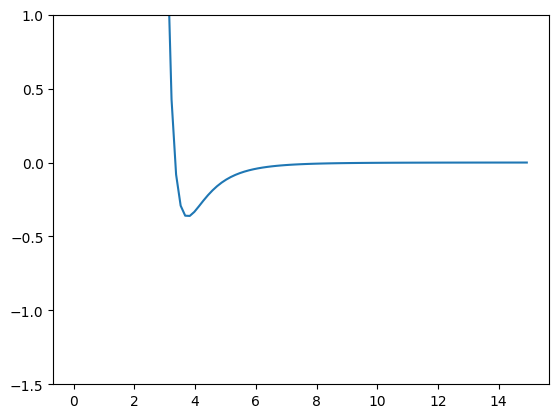

In [20]:
plt.plot(r_grid, ur[:, 0, 0])
plt.ylim([-1.5, 1.0])
plt.show()

We have our inputs (the potential energy and the intramolecular correlation function), so lets solve the RISM equation.

We're going to actually wrap a solver in a function for easier use in the future.

In [21]:
def picard_iteration(tolerance, max_step, alpha, initial_tr):
    # Set up our loop variable tr
    tr = initial_tr
    
    # Define our counter
    step = 0
    
    while True:
        # Store previous t(r)
        tr_prev = tr

        # t(r) -> c(r) from closure
        cr = HNC(beta, ur, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = RISM(cr, wk, rho, r_grid, k_grid, dr, dk)

        # Use Picard iteration to get the new solution
        # Since we set alpha = 1.0 above, this is 
        # essentially direct iteration (tr_new = f_tr).
        tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev

        # Check the absolute value of the difference between the current and previous solution
        # We use .max() because we want to check that all values are below the tolerance, and
        # if the maximum value of the difference array is below, then so must the other values be.
        # We multiply by dr to normalise this over grid spacing.
        diff = abs((tr_new - tr_prev).max()) * dr

        # Set t(r) to the new t(r) we just computed
        tr = tr_new

        # Print the iteration step every 100 steps and difference
        if step % 100 == 0:
            print("Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))

        # Test if the difference is below our tolerance
        if diff < tolerance:
            break
        
        # If we reach max_step, raise an error!
        if step == max_step:
            raise Exception("Reached max steps!")

        # Update our step counter. We have a max_step because we don't want this calculation to go 
        # on forever and freeze our PC.
        step += 1
    
    # Return solved t(r)
    return tr

Before we start the solver, there's something else we need to consider - the fbt and ifbt functions.

We wrote them for 1D arrays in mind, but we're working with 3D arrays now. If you were try to use the above function without modifying the fbt and ifbt functions, you'd see that it wouldn't work because the r and k grids are not 3D, they're 1D, but our fr and fk grids are 3D now.

We need to refactor them for 3D arrays. Fortunately this is an easy fix, we just need to introduce a new axis to the r and k grid. These are just empty axes that Numpy uses to properly broadcast a 1D array over 3D arrays.

In [22]:
def fbt(fr, r, k, dr):
    return 2.0 * np.pi * dr * dstn(fr * r[:, np.newaxis, np.newaxis], type=4, axes=[0]) / k[:, np.newaxis, np.newaxis]

def ifbt(fk, r, k, dk):
    return dk / 4.0 / np.pi / np.pi * idstn(fk * k[:, np.newaxis, np.newaxis], type=4, axes=[0]) / r[:, np.newaxis, np.newaxis]

We also have a slightly more complicated problem on our hands now. Using an initial guess of 0 might not cut it, so we'll try using the Mayer-f function as an initial guess

$$ f(r) = e^{-\beta u(r)} - 1 $$

In [23]:
tolerance = 1e-8
max_step = 1000
alpha = 0.1
initial_tr = np.exp(-beta * ur) - 1

tr = picard_iteration(tolerance, max_step, alpha, initial_tr)

Iteration: 0 Diff: 1.53e-01
Iteration: 100 Diff: 1.92e-02
Iteration: 200 Diff: 1.80e-02
Iteration: 300 Diff: 1.69e-02
Iteration: 400 Diff: 1.45e-02
Iteration: 500 Diff: 1.37e-02
Iteration: 600 Diff: 1.31e-02
Iteration: 700 Diff: 1.25e-02
Iteration: 800 Diff: 1.18e-02
Iteration: 900 Diff: 1.11e-02
Iteration: 1000 Diff: 9.97e-03


Exception: Reached max steps!

1000 iterations doesn't seem to cut it on my machine. We might need to implement a different solver.

Lets take a look at a simple convergence acceleration method called Ng acceleration.

Convergence acceleration methods are a family of numerical methods that use the history of solutions to guide towards a new solution quickly.

The basic idea of the Ng method is to save the previous 3 solutions and to use those to parametrise a new solution.

Lets write a simple function for a single Ng step

In order to do that, we need to be able to properly model the long-range electrostatics via the Coulomb potential.
A problem that arises is properly dealing with the long-range part when performing a Fourier transform - the potential will diverge!

A simple solution is to break the potential energy into two parts - a short and long range component.
Perform the fast Fourier transform for the short range component but choose the long-range component such that we can analytically transform it.

We will choose such a form in a moment, first we should define the model we want to solve.